# Hierarchical Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [1]:
import json, os
import numpy as np
import pandas as pd
import numpyro, jax
import arviz as az
import matplotlib.pyplot as plt

from matplotlib import colormaps
from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam
from time import time

num_chains = 4
numpyro.enable_x64()
numpyro.set_host_device_count(num_chains)

In [2]:
try:
    gpu = jax.devices('gpu')[0]
except RuntimeError:
    gpu = None

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Then, import the `HierarchicalStarModel` from `celestify`.

In [3]:
from celestify.numpyro_models import HierarchicalStarModel

## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [4]:
directory = "/mnt/data-storage/alexlyttle/scalable-stellar-inference"
# filename = "truths-nearest-neighbour-clean.csv"
# filename = "truths-nearest-neighbour-all.csv"
filename = "truths-clean.csv"
truths = pd.read_csv(os.path.join(directory, filename), index_col=0)
truths.head()

index  mu_a  sigma_a    Y_0  dY_dZ  sigma_Y  star  log_evol      evol  \
0      0   2.0     0.05  0.247    1.5    0.005     0 -1.009670  0.097798   
1      1   2.0     0.05  0.247    1.5    0.005     1 -0.770877  0.169482   
2      2   2.0     0.05  0.247    1.5    0.005     2 -0.433887  0.368224   
3      3   2.0     0.05  0.247    1.5    0.005     3 -0.973254  0.106352   
4      4   2.0     0.05  0.247    1.5    0.005     4 -0.848907  0.141610   

   log_mass  ...   log_Dnu     log_L     log_R  log_Teff   log_age     log_g  \
0  0.088301  ...  1.925982  0.663076  0.146007  3.854092  0.315519  4.234354   
1  0.063066  ...  1.892324  0.708976  0.158677  3.859232  0.489919  4.183779   
2  0.287360  ...  1.193770  1.672854  0.708866  3.825107 -0.061289  3.307695   
3 -0.052708  ...  2.168506 -0.204187 -0.041382  3.730970  1.036772  4.468122   
4  0.065755  ...  1.915474  0.372812  0.168498  3.770280  0.752982  4.166826   

   log_numax      mass        numax          L  
0   3.239863  1.225464  1737.250878   4.603370  
1   3.186717  1.156289  1537.152277   5.116539  
2   2.327696  1.938029   212.664904  47.081883  
3   3.535191  0.885710  3429.187848   0.624904  
4   3.214240  1.163470  1637.720160   2.359457  

[5 rows x 29 columns]

In [5]:
num_stars = 50

truths = truths.iloc[:num_stars].to_dict(orient="list")
truths = {key: np.array(value) for key, value in truths.items()}
pprint(truths)

{'Dnu': array([ 84.32997894,  78.04116058,  15.62319756, 147.40301514,
        82.31413269, 157.60884094,  19.25728226,  39.53224564,
        85.03617096, 183.81782532,  75.60413361,  58.48511887,
       173.39080811,  47.97853088, 142.37689209,  83.83307648,
       190.14198303,  38.28824997, 143.39419556,  21.77710152,
        18.82963943,  18.94343758,  69.98996735, 123.94909668,
        13.42201996, 153.43823242,  91.34793091,  11.2556076 ,
        26.43860054,  38.00499344,  72.47896576,  62.97002792,
        23.64263344,  71.548172  ,  37.9581604 , 198.65936279,
        76.51828003,  21.56055832,  27.06633377,  22.85251045,
        12.51046848,  45.56988525, 141.24230957, 132.19902039,
       140.5587616 ,  63.83969116,   3.55819631,  21.72050095,
        38.64396286, 124.82273102]),
 'L': array([ 4.60337043,  5.11653947, 47.0818834 ,  0.62490377,  2.35945746,
        0.55126372, 10.6615705 ,  4.82577078,  2.82775995,  0.37913443,
        4.94079137,  4.49609078,  0.53809474,  3.

In [6]:
filename = "truths.json"
hyperparam_names = ["mu_a", "sigma_a", "Y_0", "dY_dZ", "sigma_Y"]

# SAVE TRUTHS
with open(os.path.join(directory, filename), "r") as file:
    s = file.read()
    json_dict = json.loads(s)
    for name in hyperparam_names:
        truths[name] = json_dict[name]

In [7]:
# filename = "observables.csv"
# filename = "observables-all.csv"
filename = "observables-emulator.csv"

obs = pd.read_csv(os.path.join(directory, filename), index_col=0)
obs = obs.iloc[:num_stars].to_dict(orient="list")
obs = {key: np.array(value) for key, value in obs.items()}
pprint(obs)

{'M_H': array([-0.49312124, -0.63971114, -0.42489368,  0.24699952,  0.41624105,
        0.30010104, -0.89445746,  0.01857393,  0.02135728, -0.18861528,
       -0.23091646,  0.14745417, -0.27301964, -0.23808825,  0.05892977,
       -0.37739196, -0.0983435 , -0.02828109,  0.23535919,  0.32080877,
       -0.57422537, -0.06054858,  0.3323217 , -0.49432594, -0.22812921,
        0.23869209,  0.27981469,  0.10461925, -0.48021886,  0.15918502,
        0.39674738, -0.35266349, -0.02201891, -0.00762293, -0.11141279,
        0.27325249,  0.35499457, -0.28059417, -0.17591056, -0.52711469,
        0.21696413,  0.27959841,  0.34849596, -0.64913094,  0.05686507,
       -0.28606313, -0.3505193 ,  0.12172511,  0.07398868,  0.20987174]),
 'log_Dnu': array([1.9258337 , 1.89279521, 1.19016683, 2.1696341 , 1.91912031,
       2.20566511, 1.28628099, 1.59916639, 1.925264  , 2.26360345,
       1.88779497, 1.77209413, 2.23848176, 1.6831212 , 2.14318442,
       1.92577064, 2.28063059, 1.58934176, 2.15632153, 1.

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [8]:
observables = ["log_Teff", "log_L", "log_Dnu"]

# Create dictionary of model constants
const = {
    "M_H": dict(loc=obs["M_H"], scale=obs["sigma_M_H"], low=-0.9, high=0.5),
}

# Create model
model = HierarchicalStarModel(num_stars, observables, const=const)

pprint(model.const)  # check all constants

{'M_H': {'high': 0.5,
         'loc': array([-0.49312124, -0.63971114, -0.42489368,  0.24699952,  0.41624105,
        0.30010104, -0.89445746,  0.01857393,  0.02135728, -0.18861528,
       -0.23091646,  0.14745417, -0.27301964, -0.23808825,  0.05892977,
       -0.37739196, -0.0983435 , -0.02828109,  0.23535919,  0.32080877,
       -0.57422537, -0.06054858,  0.3323217 , -0.49432594, -0.22812921,
        0.23869209,  0.27981469,  0.10461925, -0.48021886,  0.15918502,
        0.39674738, -0.35266349, -0.02201891, -0.00762293, -0.11141279,
        0.27325249,  0.35499457, -0.28059417, -0.17591056, -0.52711469,
        0.21696413,  0.27959841,  0.34849596, -0.64913094,  0.05686507,
       -0.28606313, -0.3505193 ,  0.12172511,  0.07398868,  0.20987174]),
         'low': -0.9,
         'scale': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,

## Prior Predictive

Sample from the model prior.

In [9]:
num_samples = 1000

rng = random.PRNGKey(0)
rng, key = random.split(rng)

prior_predictive = Predictive(model, num_samples=num_samples)
with jax.default_device(gpu):
    prior = prior_predictive(key)
y = prior.pop("y")
for i, key in enumerate(model.outputs):
    prior[key] = y[..., i]

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [10]:
coords = {"star": np.arange(num_stars)}
dims = {}
for key, value in prior.items():
    dims[key] = dim = []
    if value.ndim == 1:
        continue
    if value.shape[-1] == num_stars:
        dim.append("star")

data = az.from_numpyro(prior=prior, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

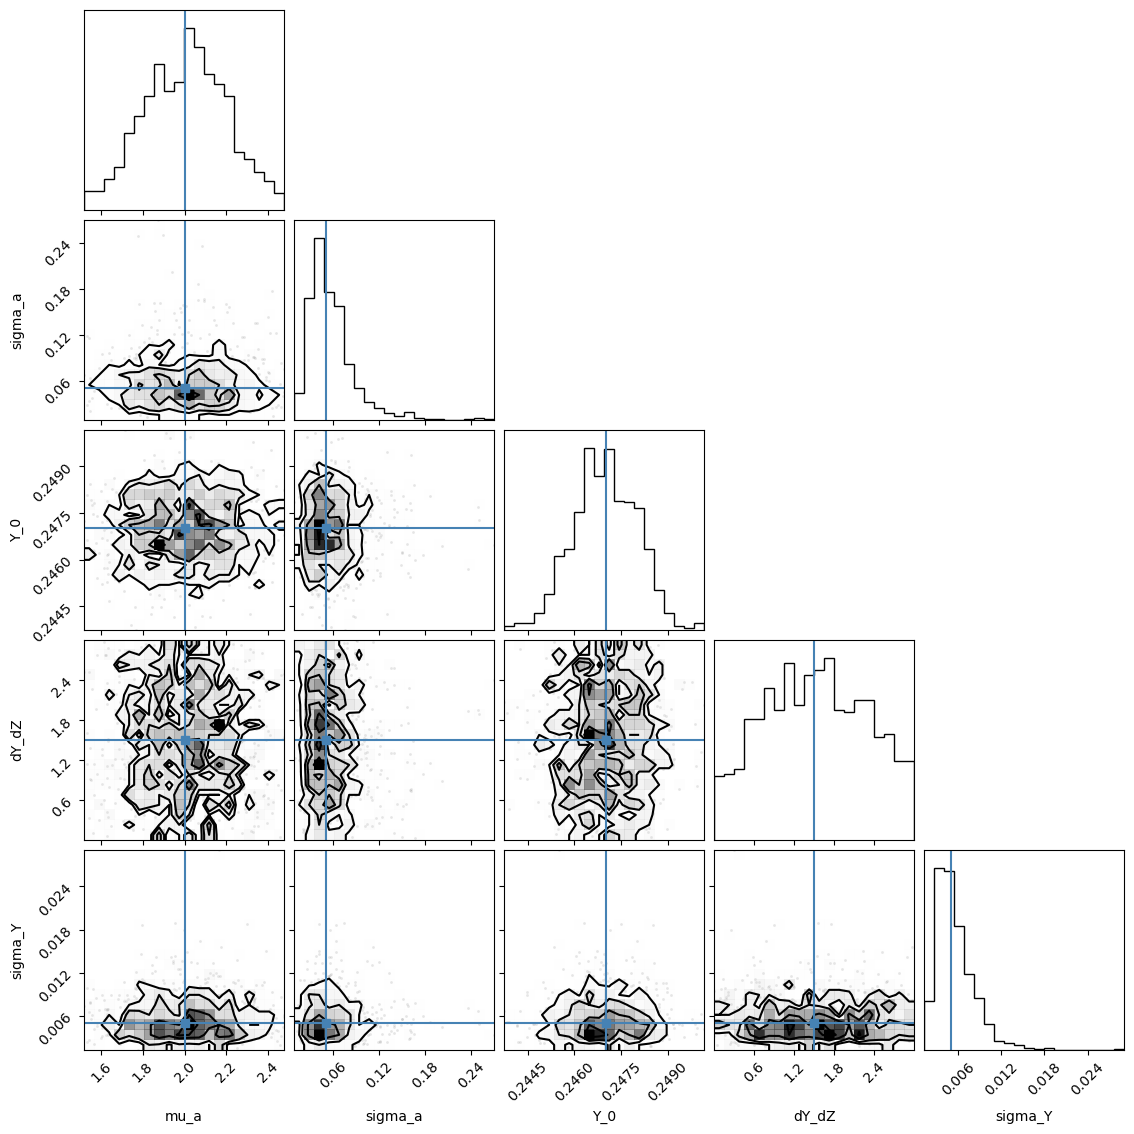

In [11]:
fig = corner(data, group="prior", var_names=hyperparam_names, truths=truths)

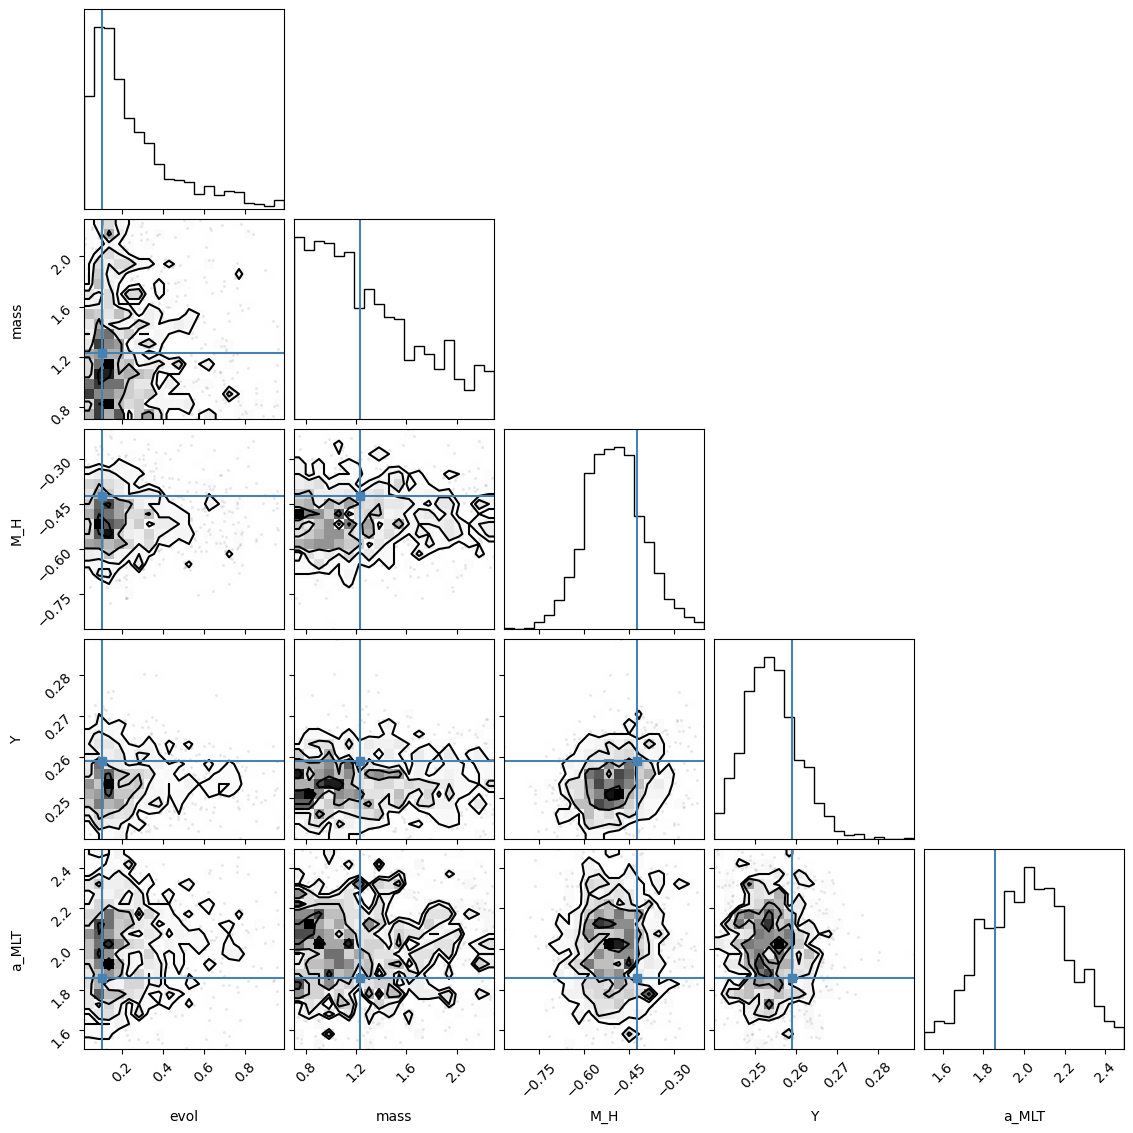

In [12]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

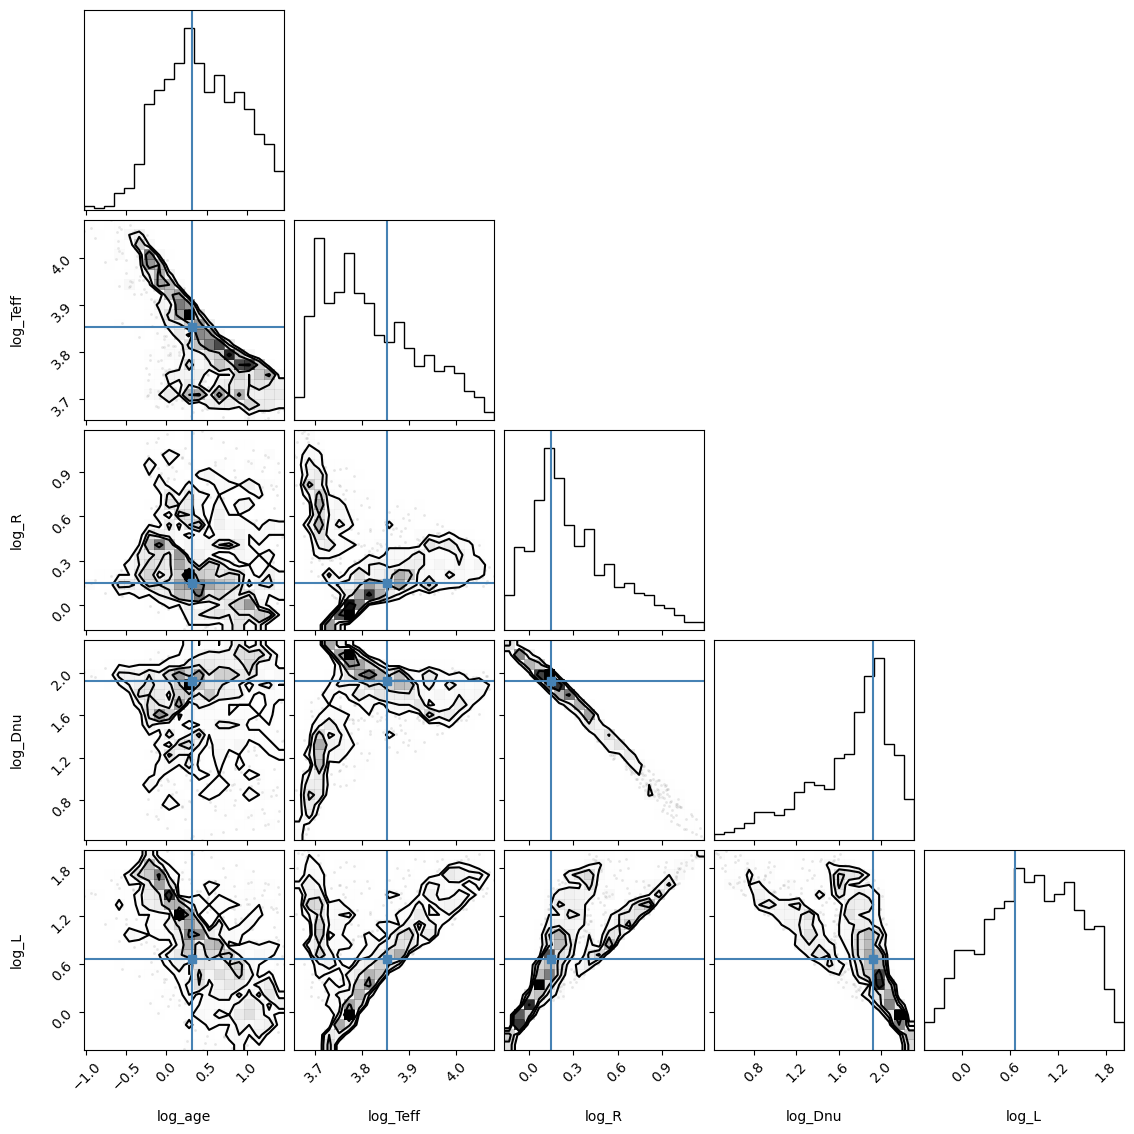

In [13]:
star = 0
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

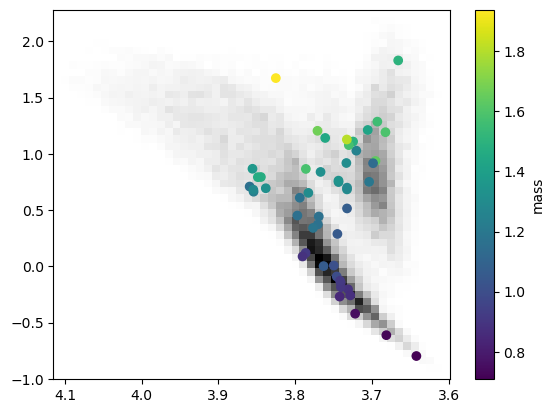

In [14]:
fig, ax = plt.subplots()

ax.hist2d(
    data.prior.log_Teff.values.ravel(), 
    data.prior.log_L.values.ravel(), 
    bins=50, 
    cmap="Grays"
)
s = ax.scatter(
    truths["log_Teff"], 
    truths["log_L"], 
    c=truths["mass"]
)
ax.invert_xaxis()
fig.colorbar(s, label="mass");

## Observation

Now we synthesize observable parameters for the model.

In [15]:
y = np.stack([obs[key] for key in observables], axis=-1)
diag = np.stack([obs[f"sigma_{key}"] for key in observables], axis=-1)**2
pprint(y)
pprint(diag)

array([[ 3.85499692e+00,  6.54403090e-01,  1.92583370e+00],
       [ 3.87129736e+00,  7.01672792e-01,  1.89279521e+00],
       [ 3.82335639e+00,  1.67968893e+00,  1.19016683e+00],
       [ 3.72110152e+00, -1.93382233e-01,  2.16963410e+00],
       [ 3.77260804e+00,  3.75000954e-01,  1.91912031e+00],
       [ 3.72987294e+00, -2.51568168e-01,  2.20566511e+00],
       [ 3.72038603e+00,  1.03255761e+00,  1.28628099e+00],
       [ 3.71442986e+00,  6.79279506e-01,  1.59916639e+00],
       [ 3.79160118e+00,  4.30307180e-01,  1.92526400e+00],
       [ 3.73200893e+00, -4.10426825e-01,  2.26360345e+00],
       [ 3.83727431e+00,  6.97197855e-01,  1.88779497e+00],
       [ 3.77751803e+00,  6.61151528e-01,  1.77209413e+00],
       [ 3.73597717e+00, -2.59297520e-01,  2.23848176e+00],
       [ 3.73377252e+00,  5.24842203e-01,  1.68312120e+00],
       [ 3.74715114e+00, -8.94557983e-02,  2.14318442e+00],
       [ 3.86982751e+00,  6.75622940e-01,  1.92577064e+00],
       [ 3.69776535e+00, -5.91776192e-01

## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [16]:
# sampler = NUTS(model, target_accept_prob=0.8, dense_mass=[("dY_dZ", "da_dM", "sigma_Y", "sigma_a")], init_strategy=init_to_median)
# sampler = NUTS(model, target_accept_prob=0.9, init_strategy=init_to_median, find_heuristic_step_size=True, max_tree_depth=11)
num_warmup, num_samples = 2000, 2000

sampler = NUTS(model, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

Let's run the MCMC and print a summary of results.

In [17]:
rng, key = random.split(rng)
start = time()
with jax.default_device(gpu):
    mcmc.run(key, obs=y, diag=diag)
# mcmc.run(key, obs=y, diag=diag)
elapsed_time = time() - start
mcmc.print_summary()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
              M_H[0]     -0.50      0.09     -0.51     -0.66     -0.36   3451.63      1.00
              M_H[1]     -0.66      0.09     -0.67     -0.82     -0.51   2706.74      1.00
              M_H[2]     -0.43      0.10     -0.43     -0.58     -0.26   4248.88      1.00
              M_H[3]      0.28      0.09      0.28      0.13      0.43   4850.15      1.00
              M_H[4]      0.40      0.07      0.41      0.29      0.50   2683.03      1.00
              M_H[5]      0.27      0.09      0.27      0.12      0.42   3647.91      1.00
              M_H[6]     -0.81      0.07     -0.82     -0.90     -0.72    627.34      1.01
              M_H[7]      0.09      0.09      0.09     -0.07      0.24   4506.87      1.00
              M_H[8]      0.02      0.10      0.02     -0.14      0.20   3568.44      1.00
              M_H[9]     -0.24      0.08     -0.24     -0.38     -0.11   4500.47      1.0

Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [18]:
posterior = mcmc.get_samples(group_by_chain=True)
sample_stats = mcmc.get_extra_fields(group_by_chain=True)

rng, key = random.split(rng)
posterior_predictive = Predictive(model, posterior_samples=posterior, parallel=True, return_sites=["y"], batch_ndims=2)
y = posterior_predictive(key)["y"]

for i, key in enumerate(model.outputs):
    posterior[key] = y[..., i]

sample_stats = mcmc.get_extra_fields(group_by_chain=True)

data += az.from_dict(posterior, sample_stats=sample_stats, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> sample_stats
	> prior

With `arviz`, we can create a summary of the data.

In [19]:
summary = az.summary(data, fmt="xarray")
summary

<xarray.Dataset>
Dimensions:           (star: 50, metric: 9)
Coordinates:
  * star              (star) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
Data variables: (12/24)
    M_H               (metric, star) float64 -0.5043 -0.6639 ... 1.001 1.001
    Y                 (metric, star) float64 0.2533 0.2521 0.2543 ... 1.01 1.009
    Y_0               (metric) float64 0.2469 0.0009927 0.2451 ... 6.866e+03 1.0
    Y_decentered      (metric, star) float64 0.09459 0.1804 ... 1.001 1.0
    a_MLT             (metric, star) float64 2.034 2.033 2.033 ... 1.007 1.006
    a_decentered      (metric, star) float64 0.01363 -0.003937 ... 1.001 1.0
    ...                ...
    log_Teff          (metric, star) float64 3.853 3.859 3.824 ... 1.001 1.002
    log_R             (metric, star) float64 0.1434 0.1571 ... 1.001 1.003
    log_Dnu           (metric, star) float64 1.926 1.894 1.19 ... 1.0 1.0 0.9999
    log_L             (metric, star) float64 0.6545 0.7054 1.68 ... 1.0 1.0 1.0
    log_g             (metric, star) float64 4.23 4.184 3.305 ... 1.0 1.001
    log_numax         (metric, star) float64 3.236 3.187 2.326 ... 1.0 1.001

In [28]:
summary_nan = summary.where(summary.sel(metric="r_hat") < 1.1).to_array()
summary_nan

<xarray.DataArray (variable: 17, metric: 9, star: 50)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * star      (star) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * metric    (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
  * variable  (variable) object 'M_H' 'Y' 'Y_0' ... 'sigma_Y' 'sigma_a'

In [29]:
summary_stacked = summary_nan.stack(x=["variable", "metric", "star"])
null_coords = summary_stacked[summary_stacked.isnull()].coords
bad_stars = set(null_coords["star"].values)
print(bad_stars)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}


In [30]:
efficiency = summary.sel(metric="ess_bulk") / elapsed_time

In [31]:
values = []
for value in efficiency.values():
    values.append(np.atleast_1d(value))

eff = np.concatenate(values)

Text(0, 0.5, 'Count')

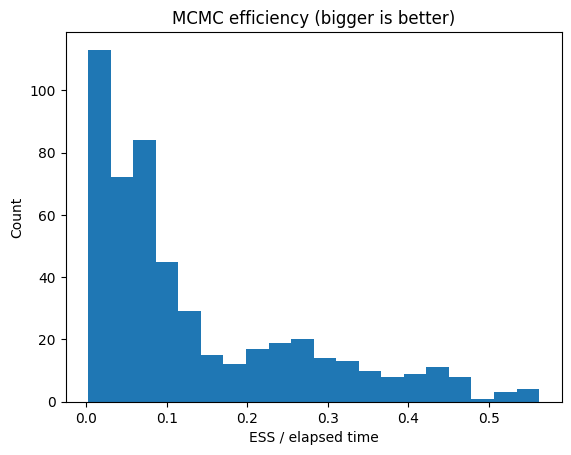

In [32]:
fig, ax = plt.subplots()

ax.hist(eff, bins=20)
ax.set_title("MCMC efficiency (bigger is better)")
ax.set_xlabel("ESS / elapsed time")
ax.set_ylabel("Count")

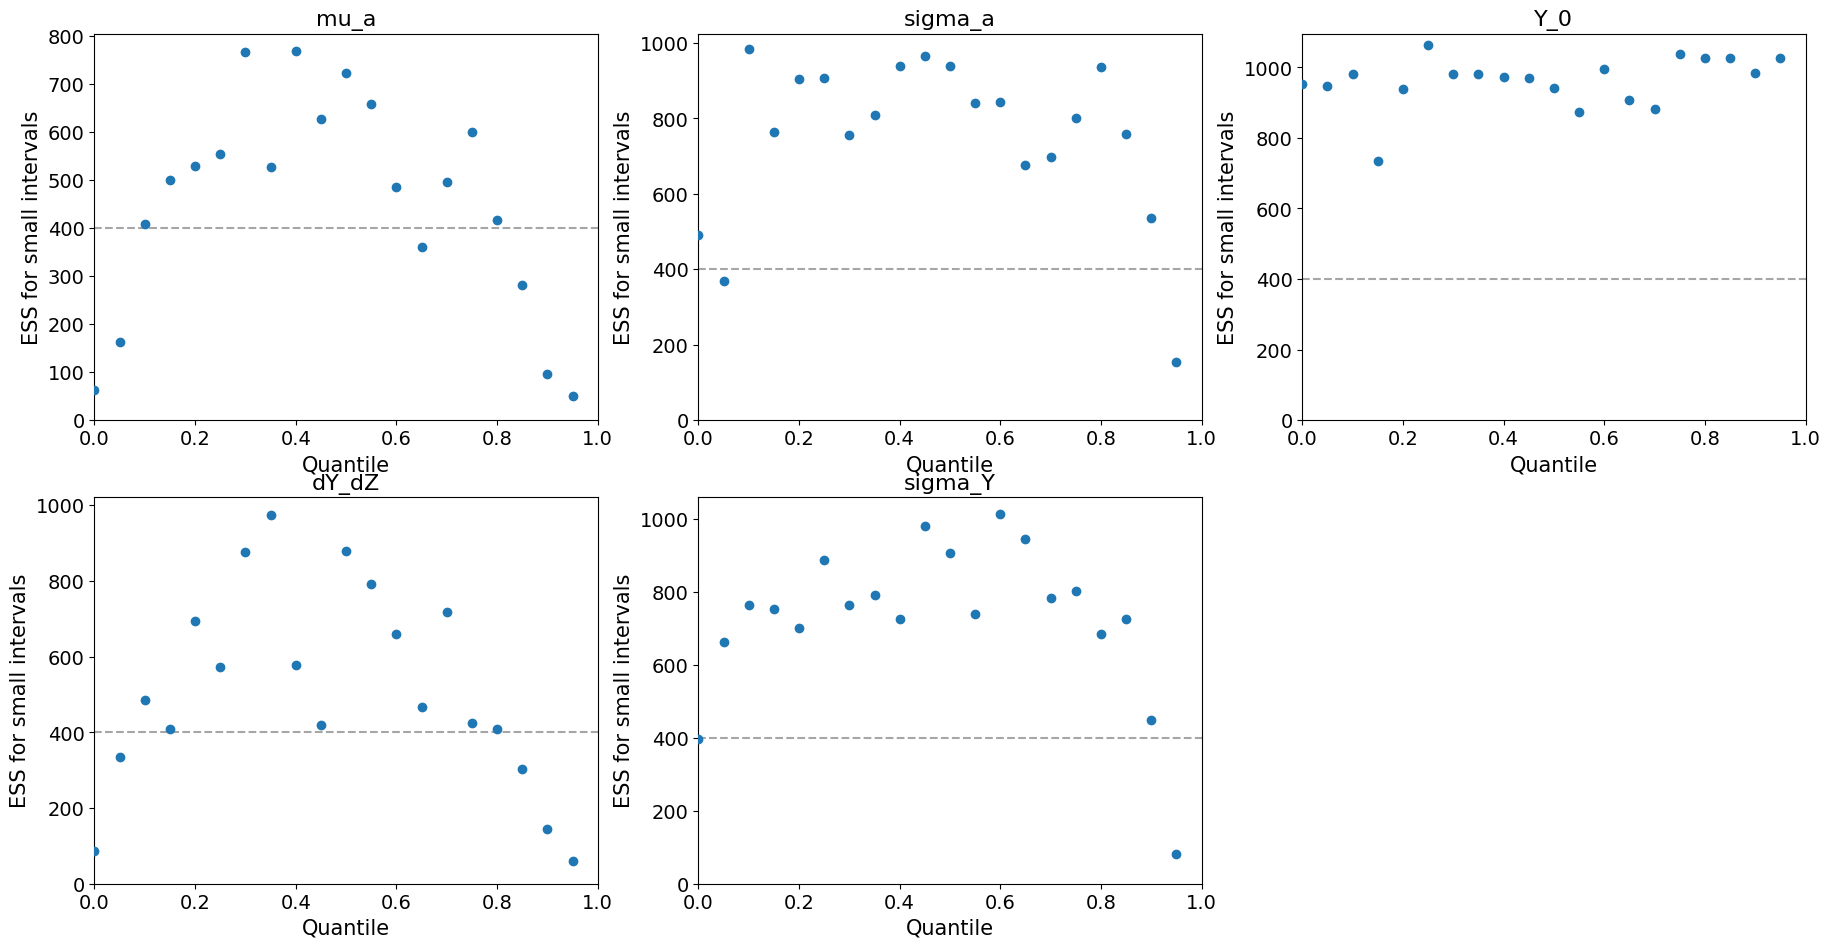

In [33]:
az.plot_ess(data, var_names=hyperparam_names);

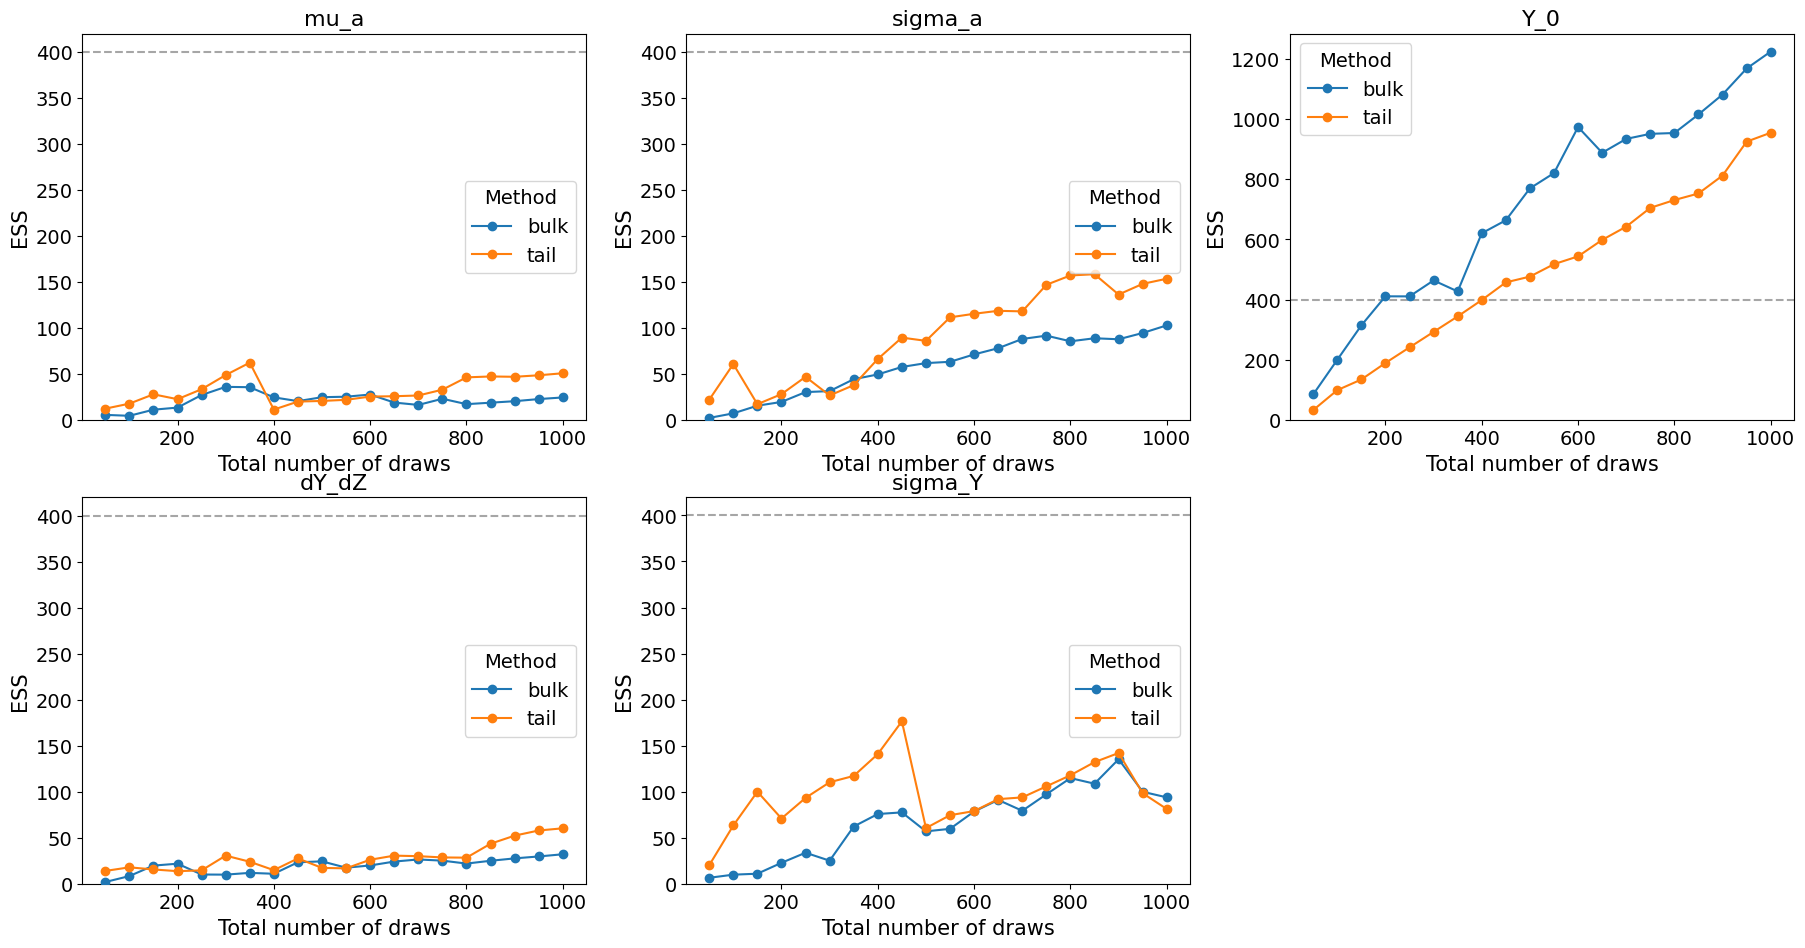

In [34]:
az.plot_ess(data, kind="evolution", var_names=hyperparam_names);

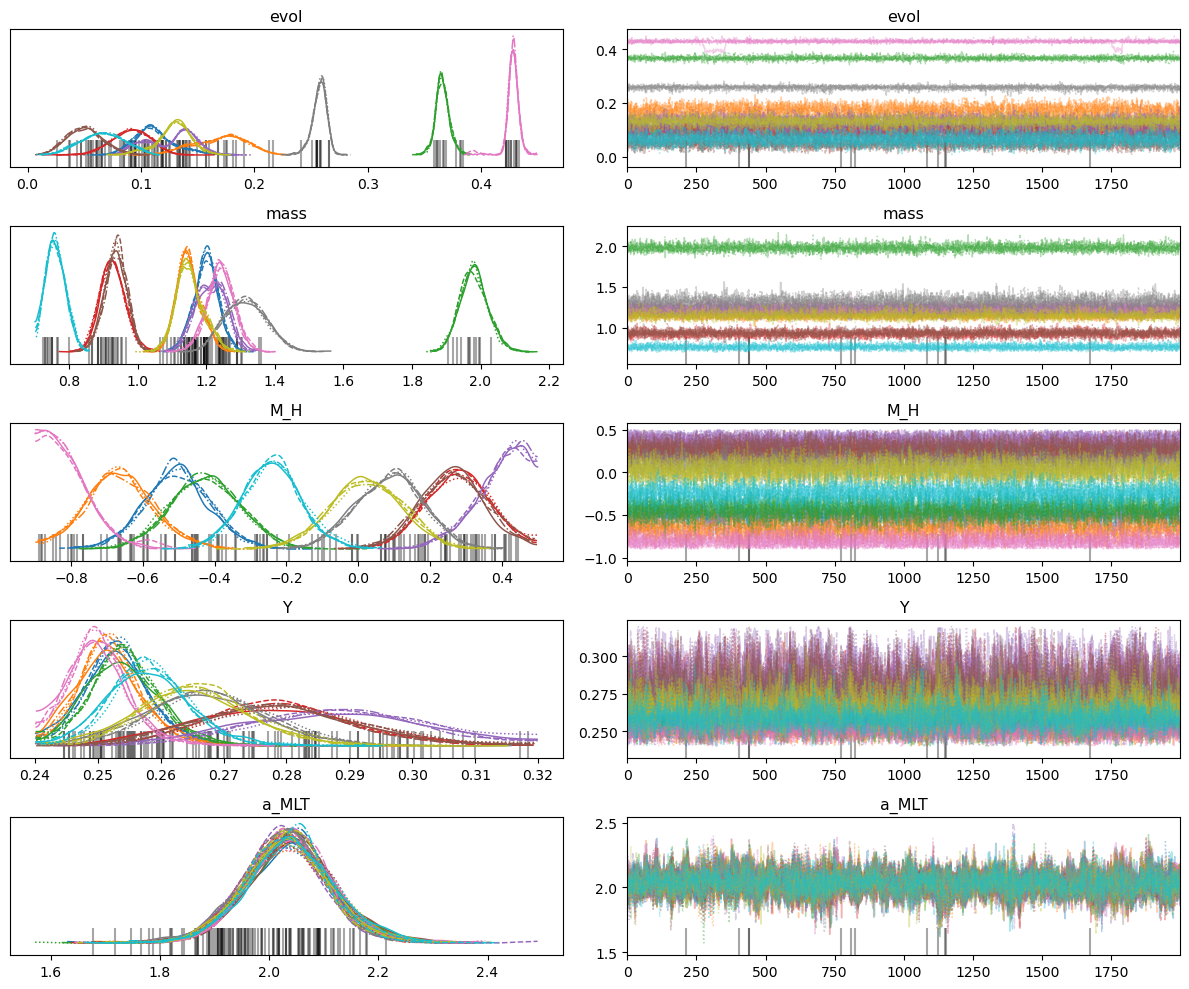

In [20]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names, coords=dict(star=range(min(num_stars, 10))))
plt.tight_layout()

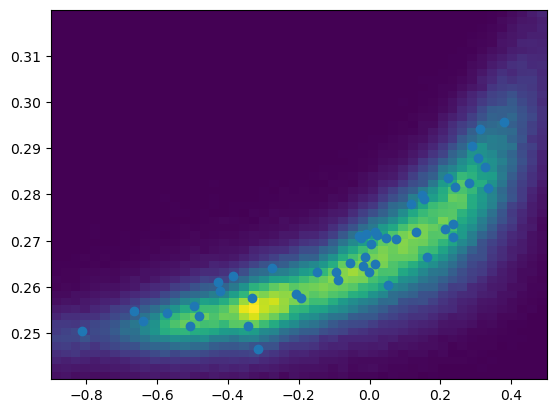

In [21]:
mh = data.posterior.M_H.values.flatten()
y = data.posterior.Y.values.flatten()
plt.hist2d(mh, y, bins=50)
plt.scatter(truths["M_H"], truths["Y"]);

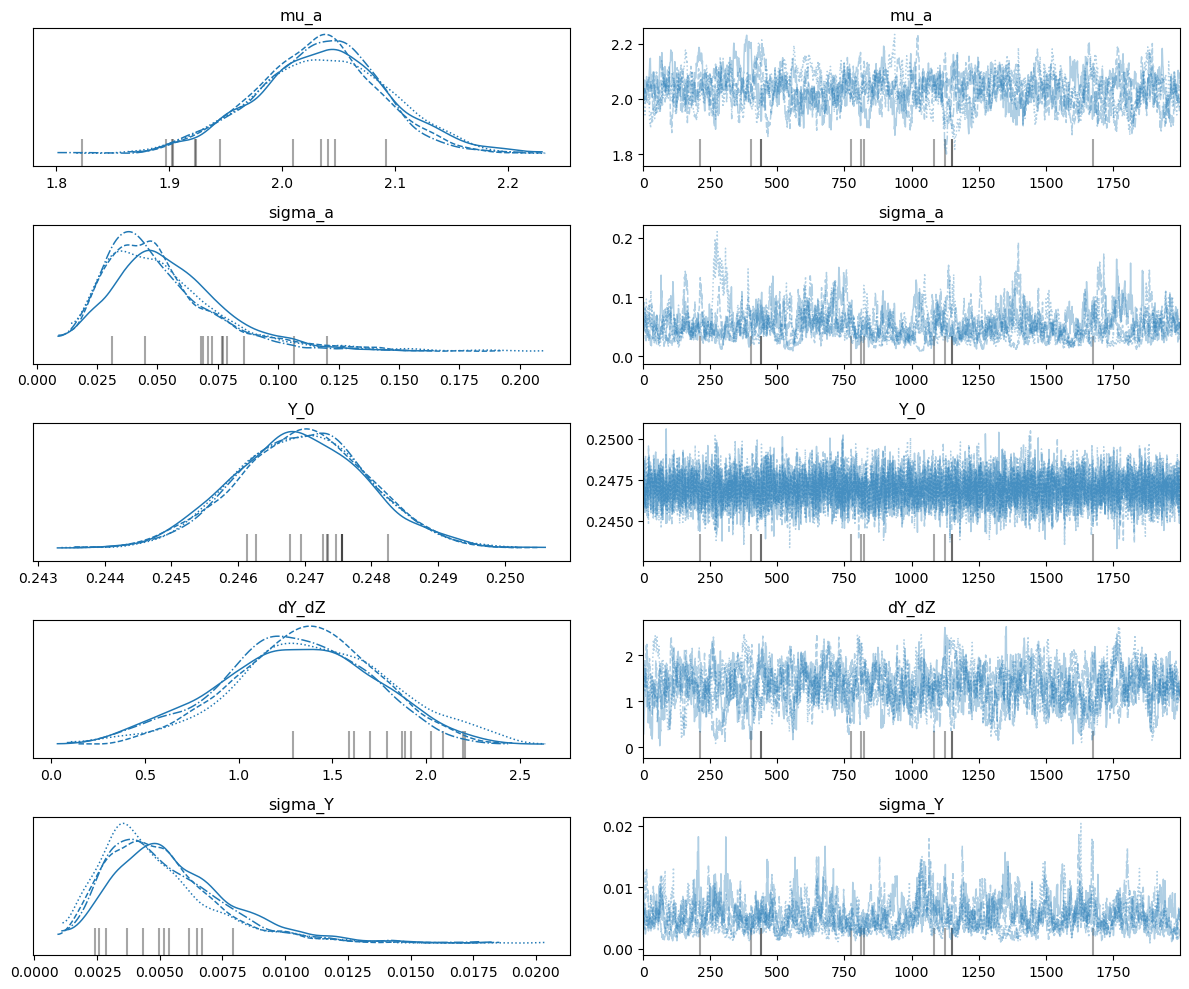

In [22]:
az.plot_trace(data, var_names=hyperparam_names)
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

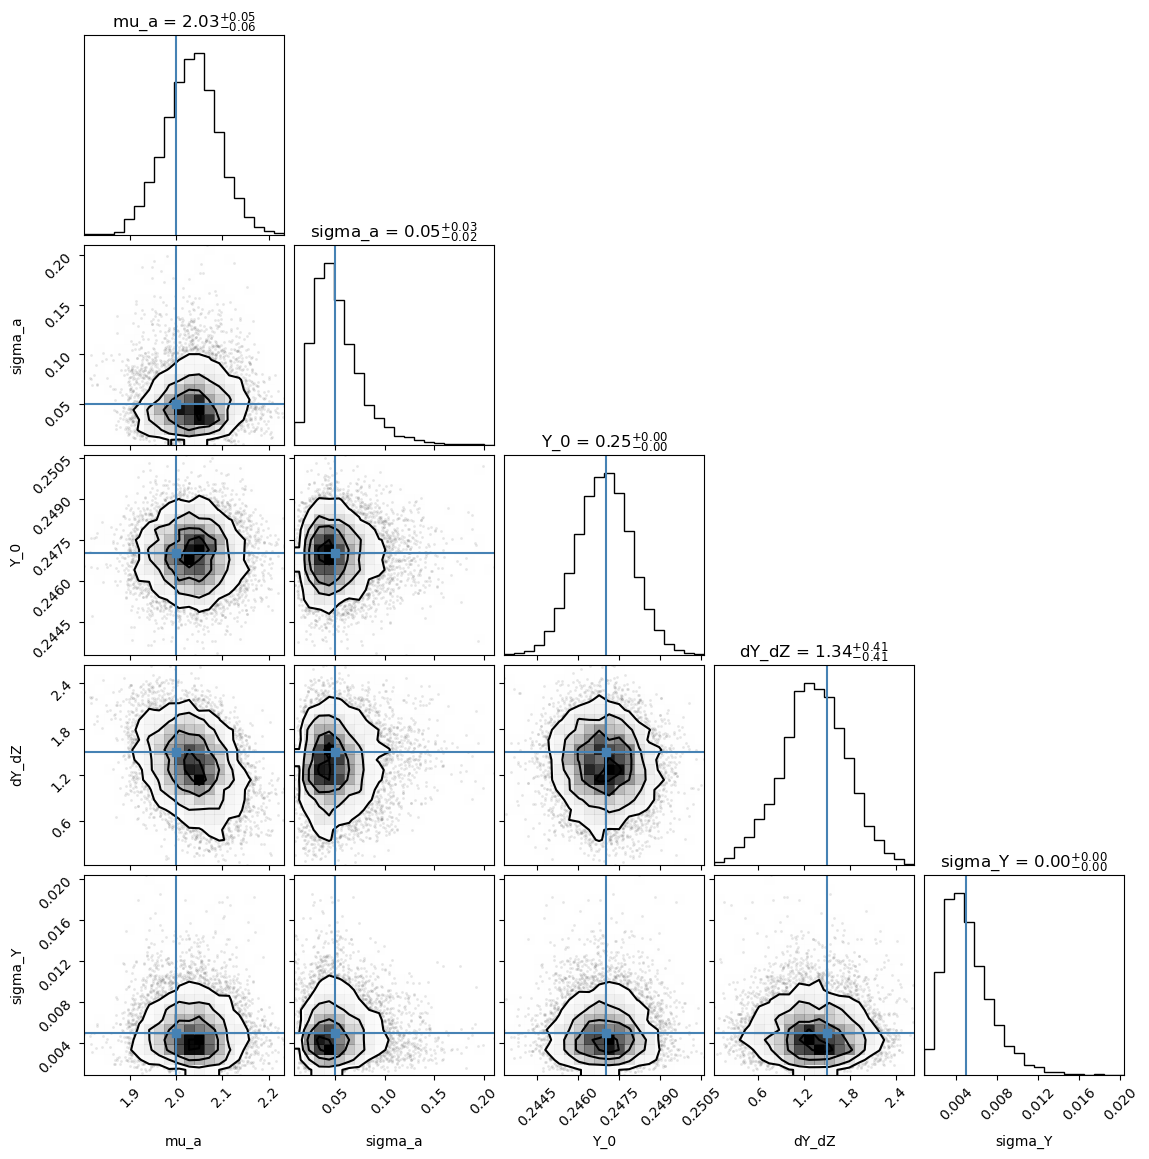

In [23]:
fig = corner(data, group="posterior", var_names=hyperparam_names, truths=truths, show_titles=True)

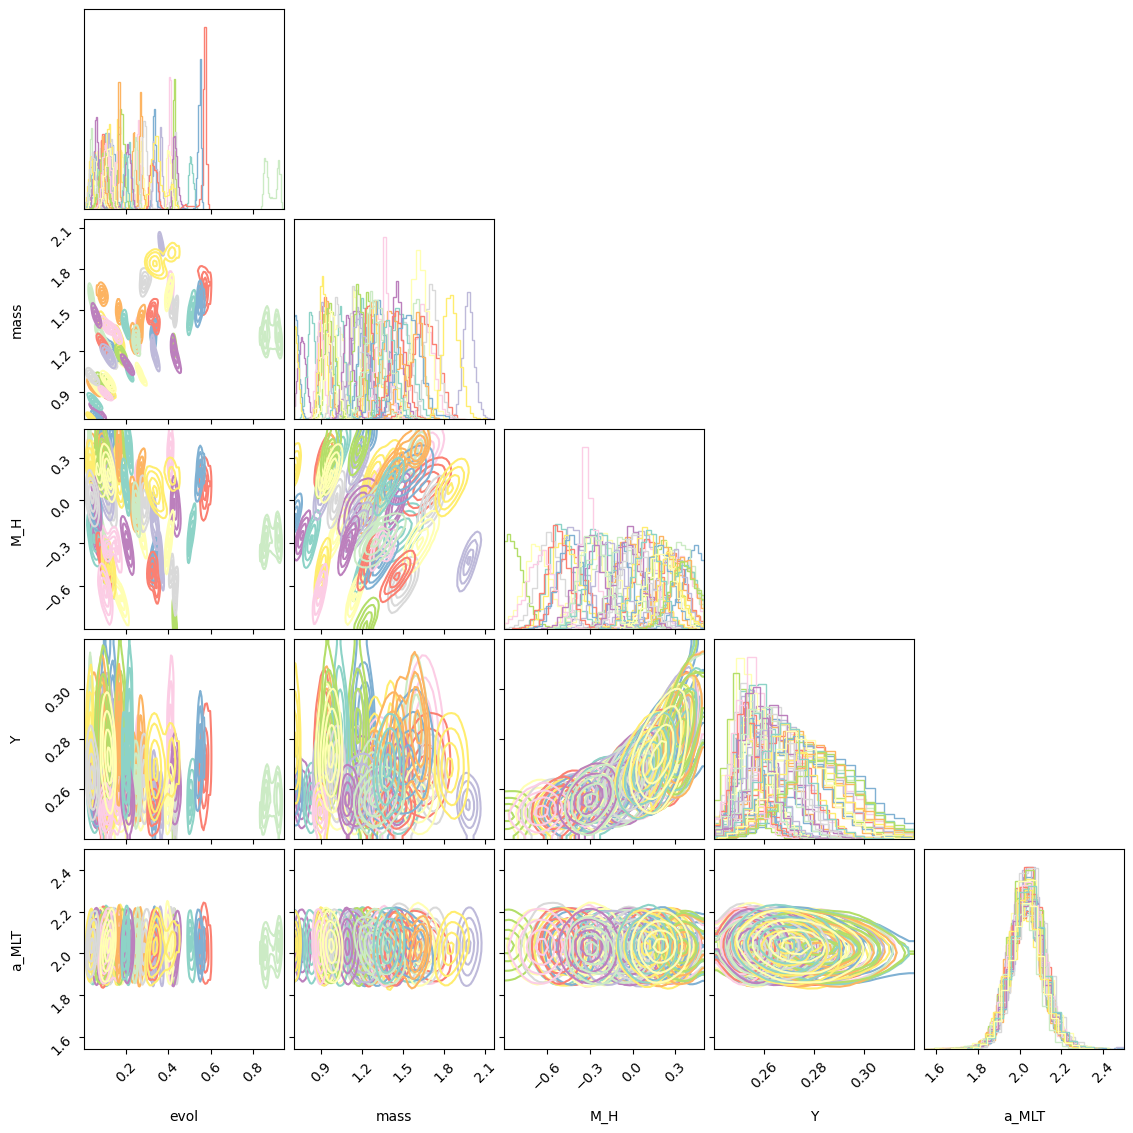

In [24]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
max_stars = min(num_stars, 100)
cmap = colormaps["Set3"]
fig = None
for star in range(max_stars):
    coords_ = {"star": star}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(data, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)

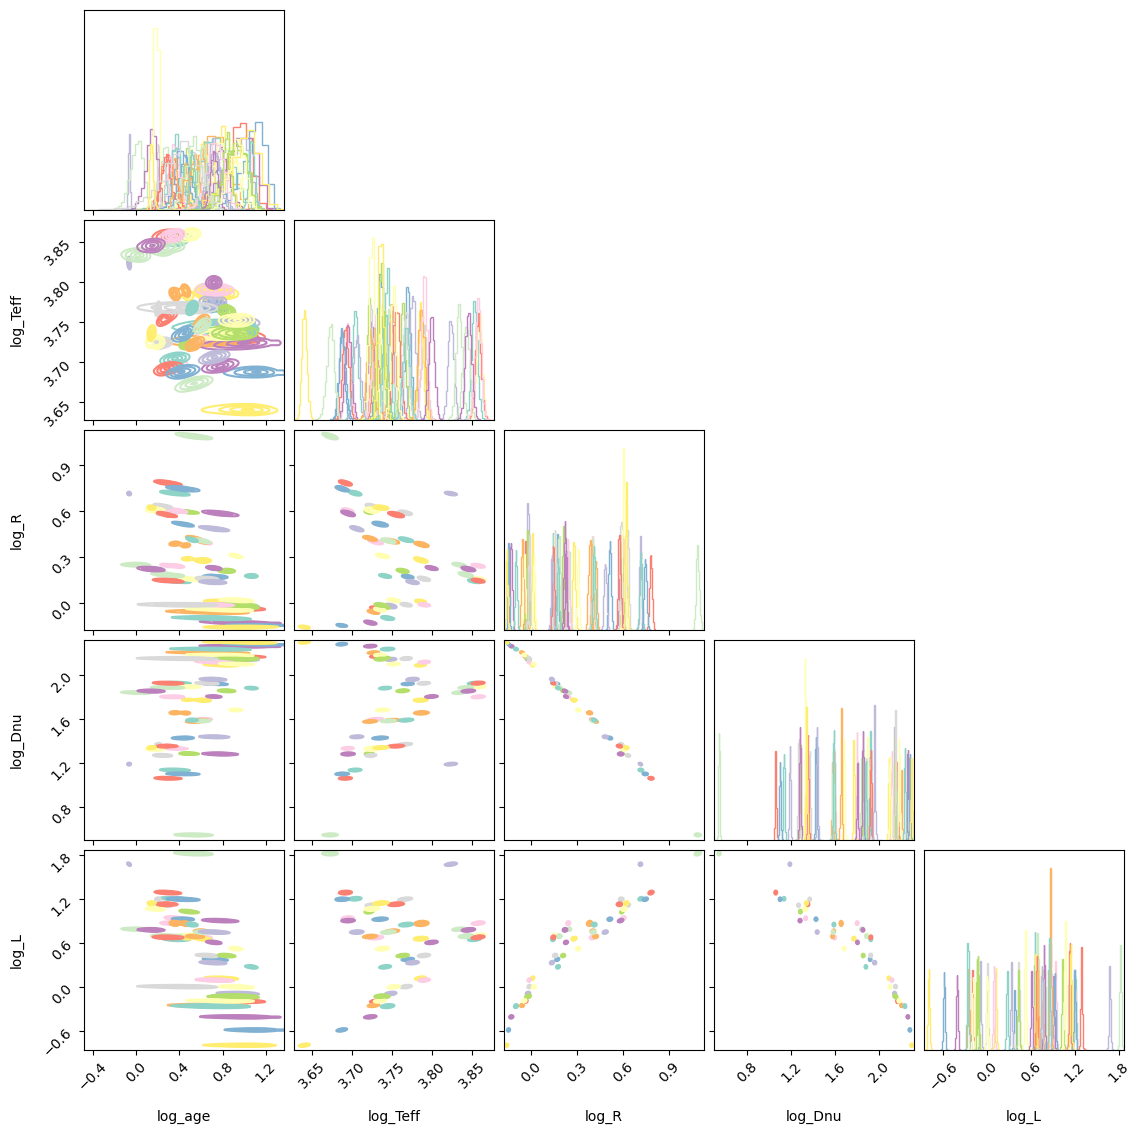

In [25]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
cmap = colormaps["Set3"]
fig = None
for star in range(max_stars):
    coords_ = {"star": star}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(data, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)

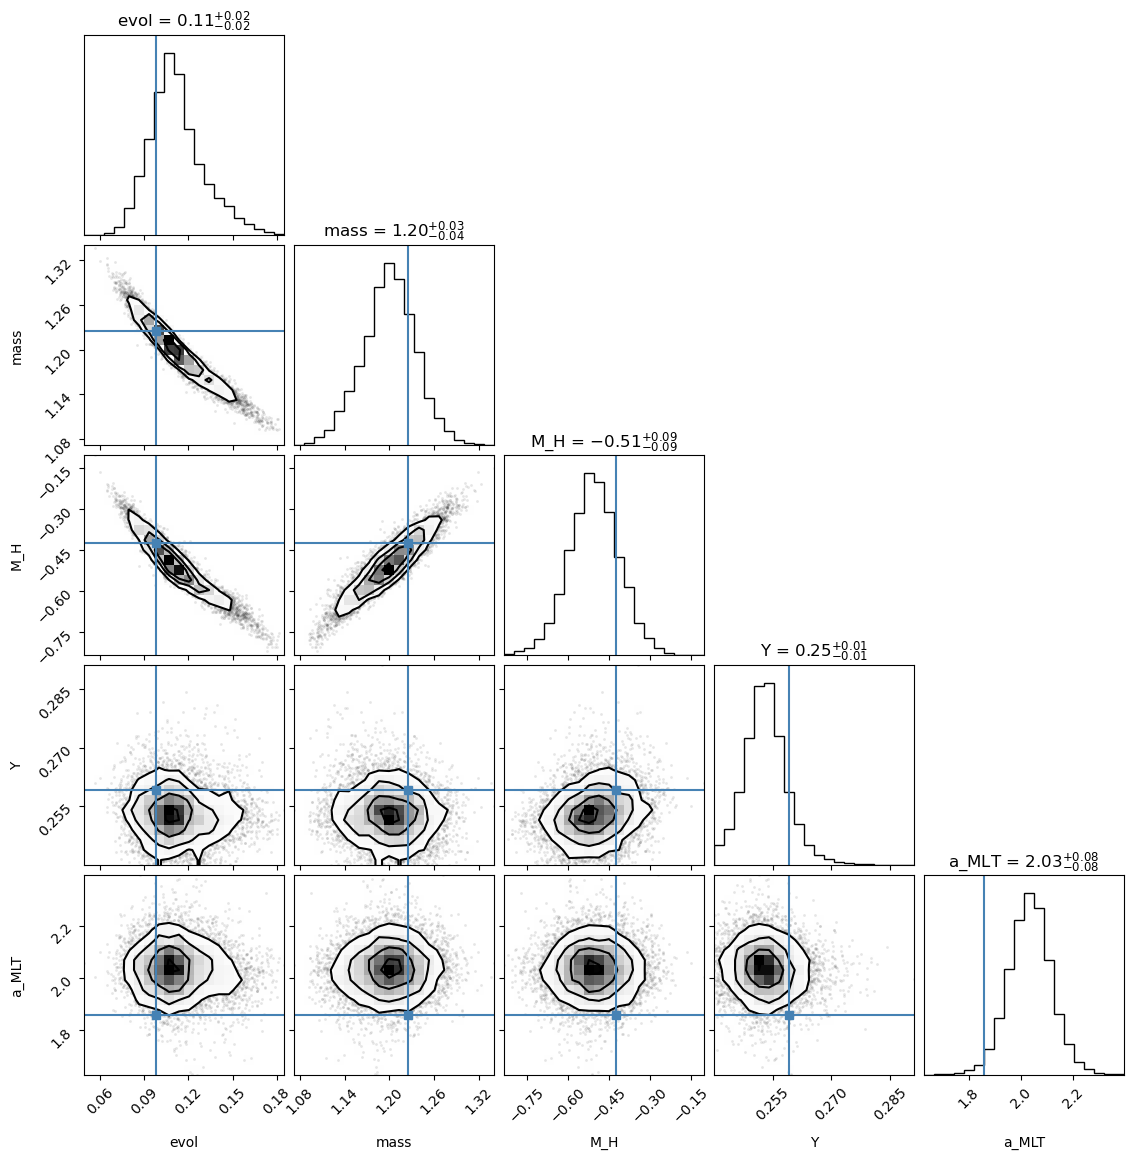

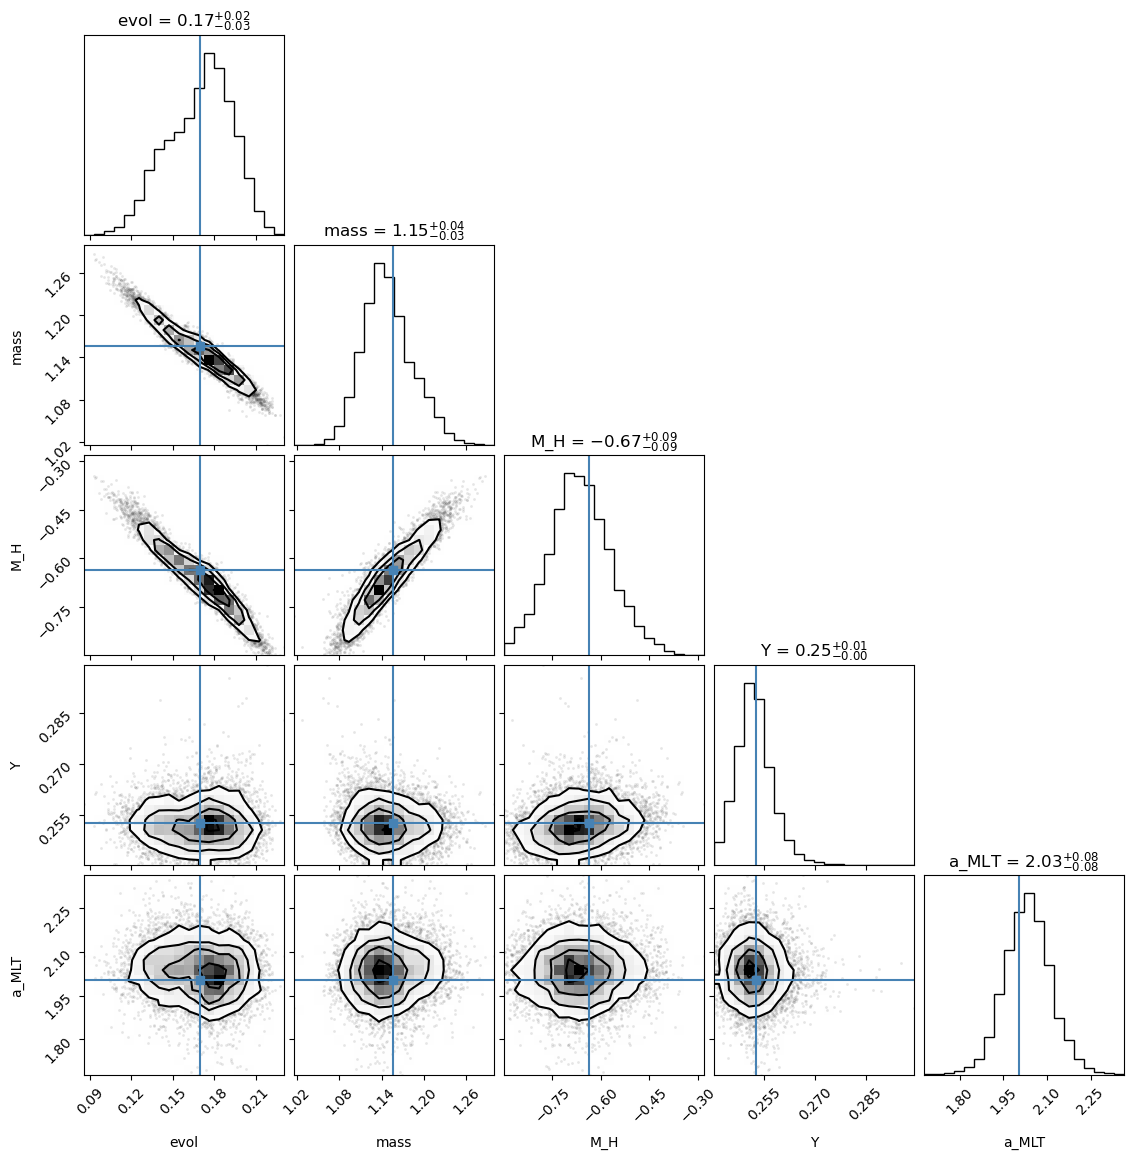

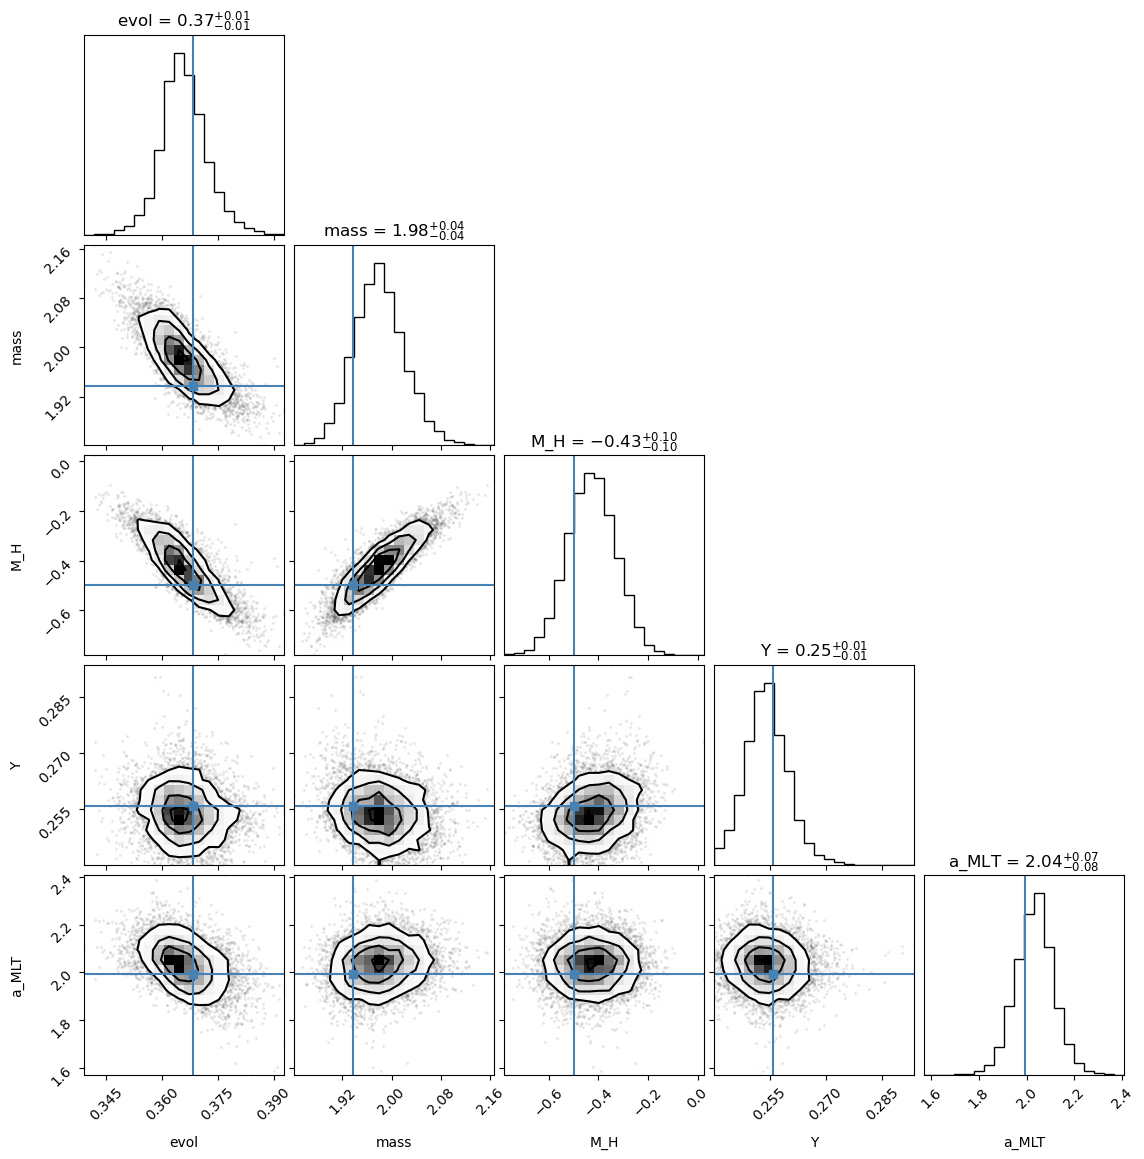

In [26]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_, show_titles=True)

What do we predict for some deterministics?

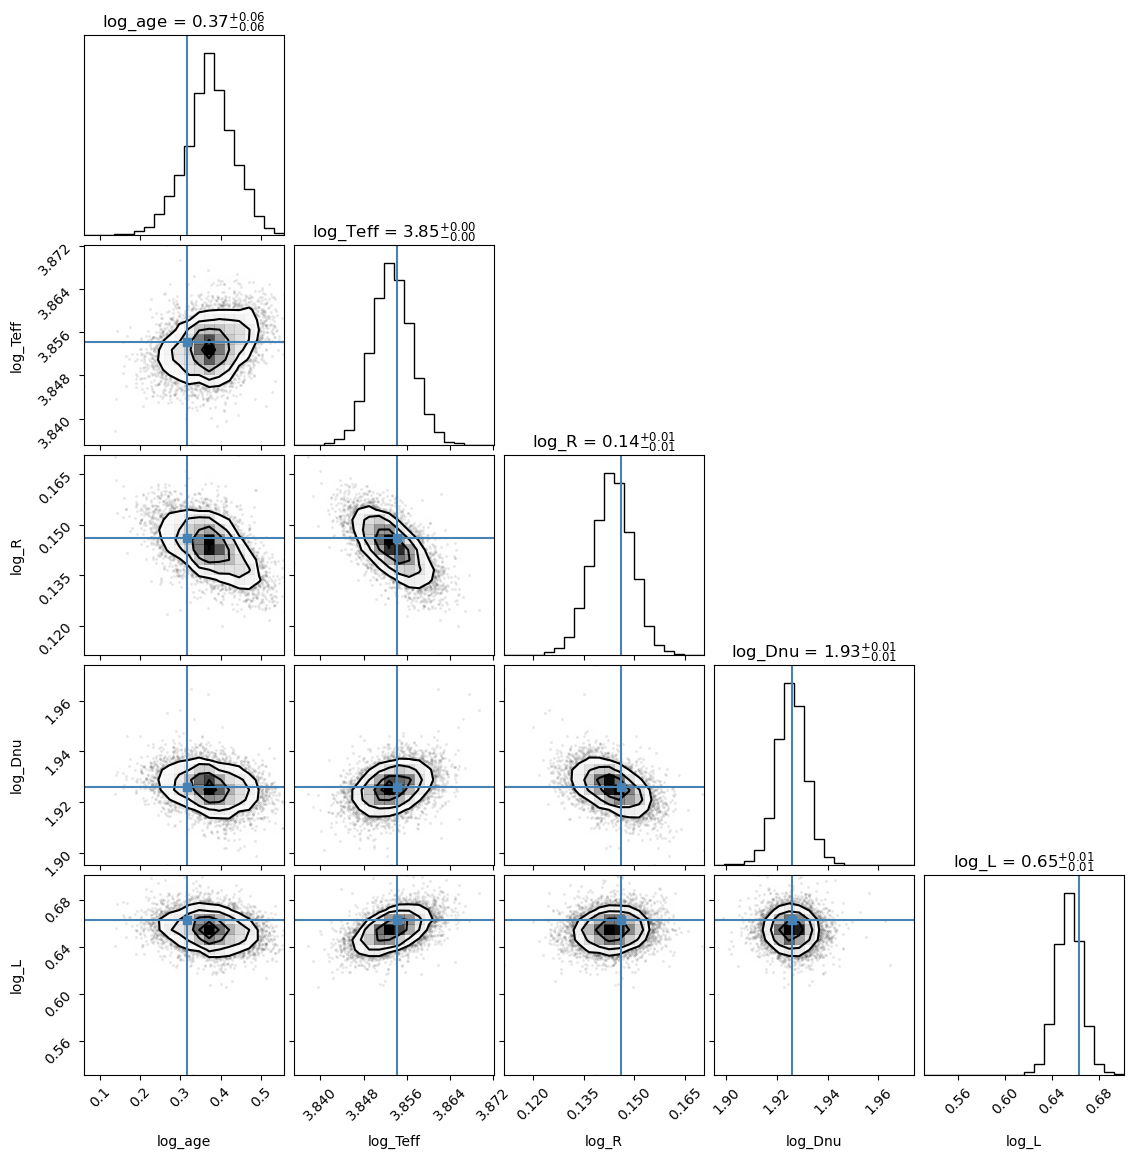

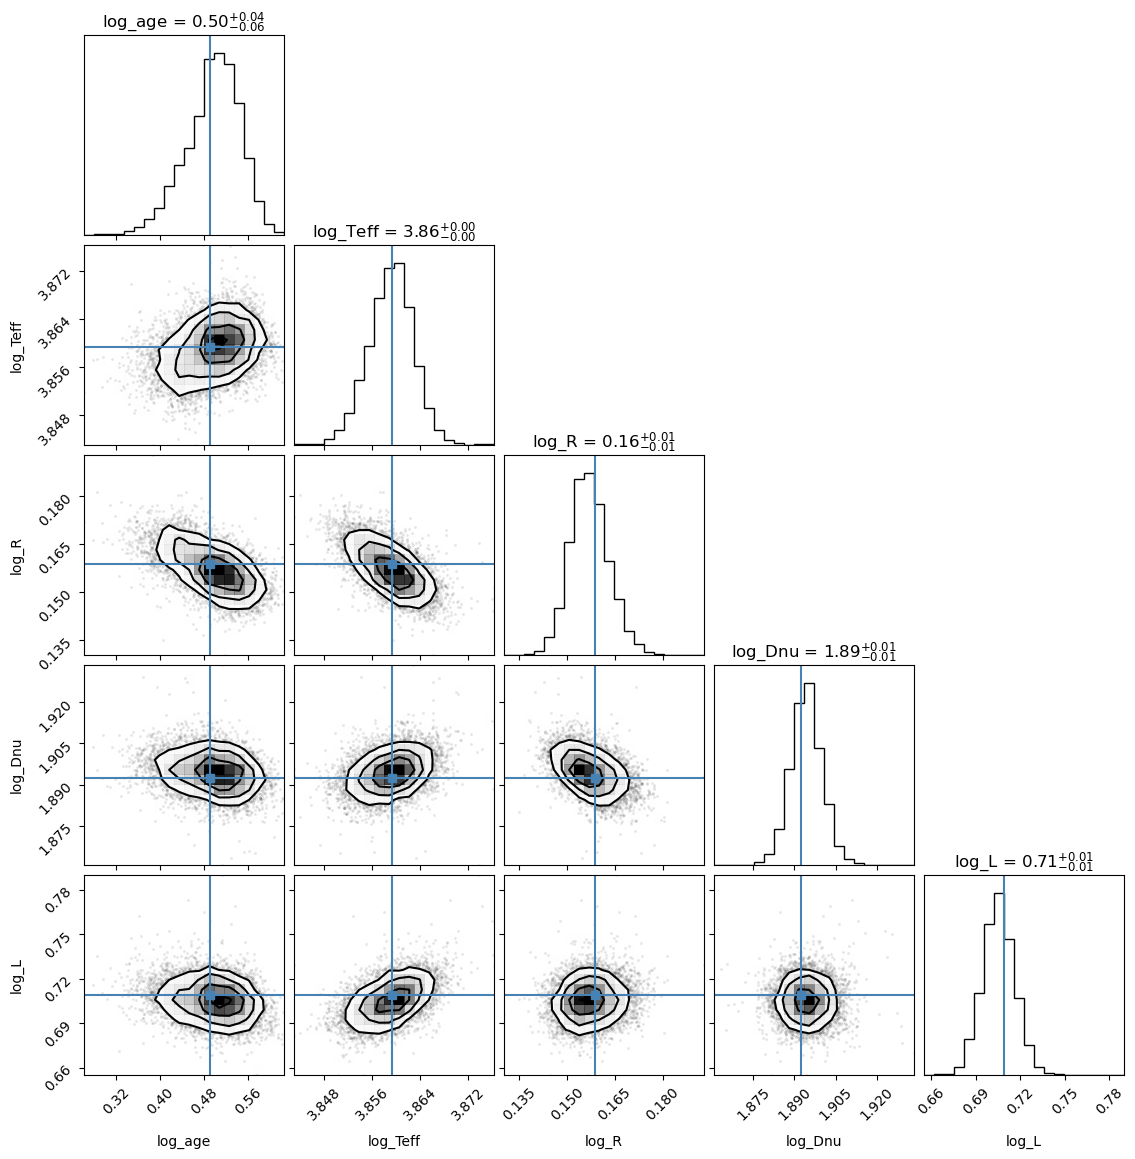

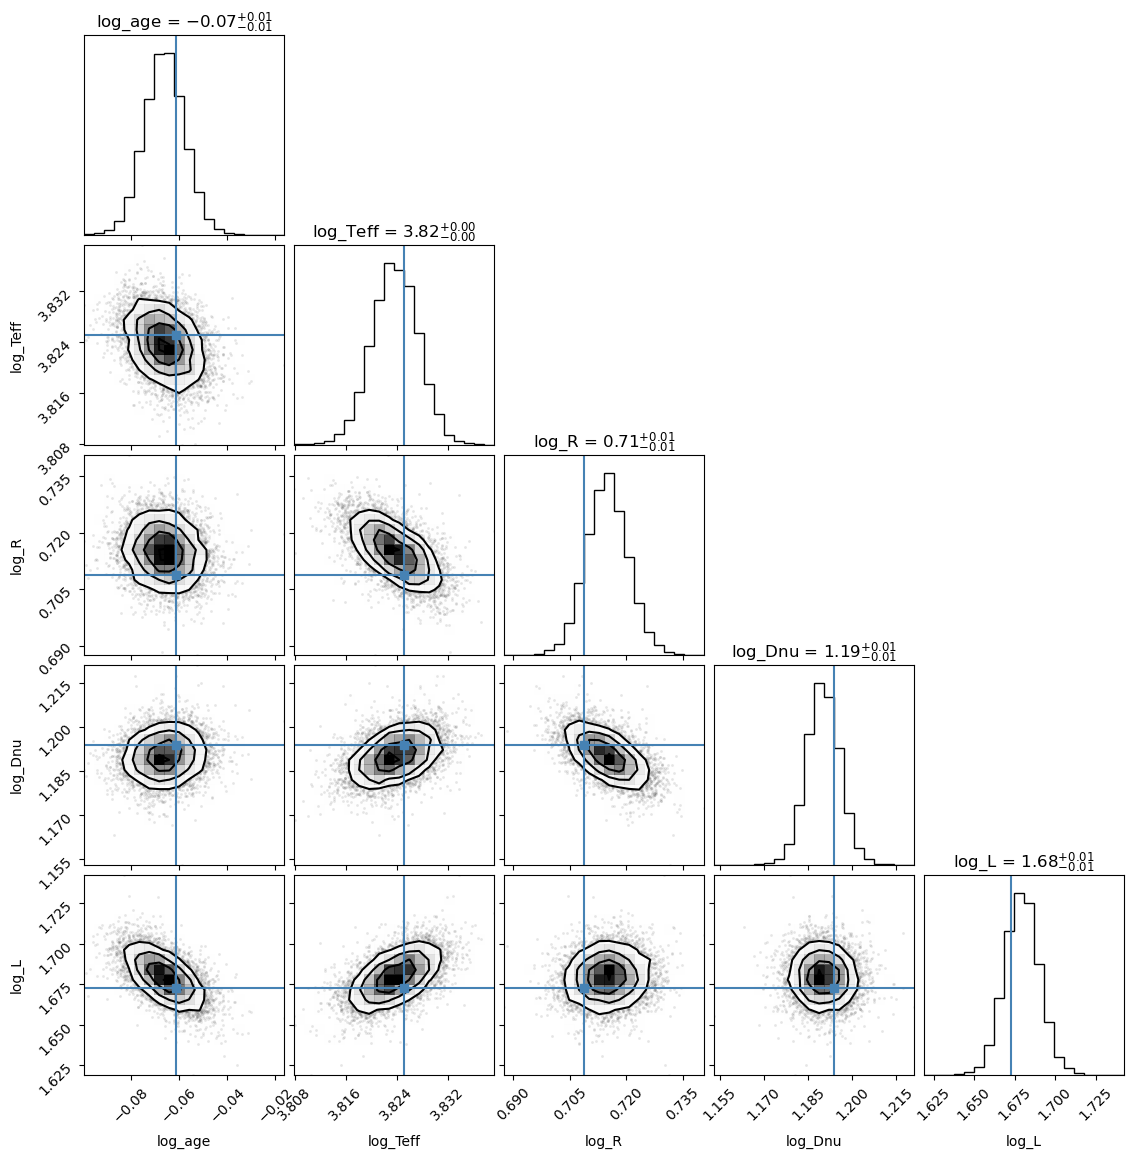

In [27]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, var_names=var_names, truths=truths_, coords=coords_, show_titles=True)

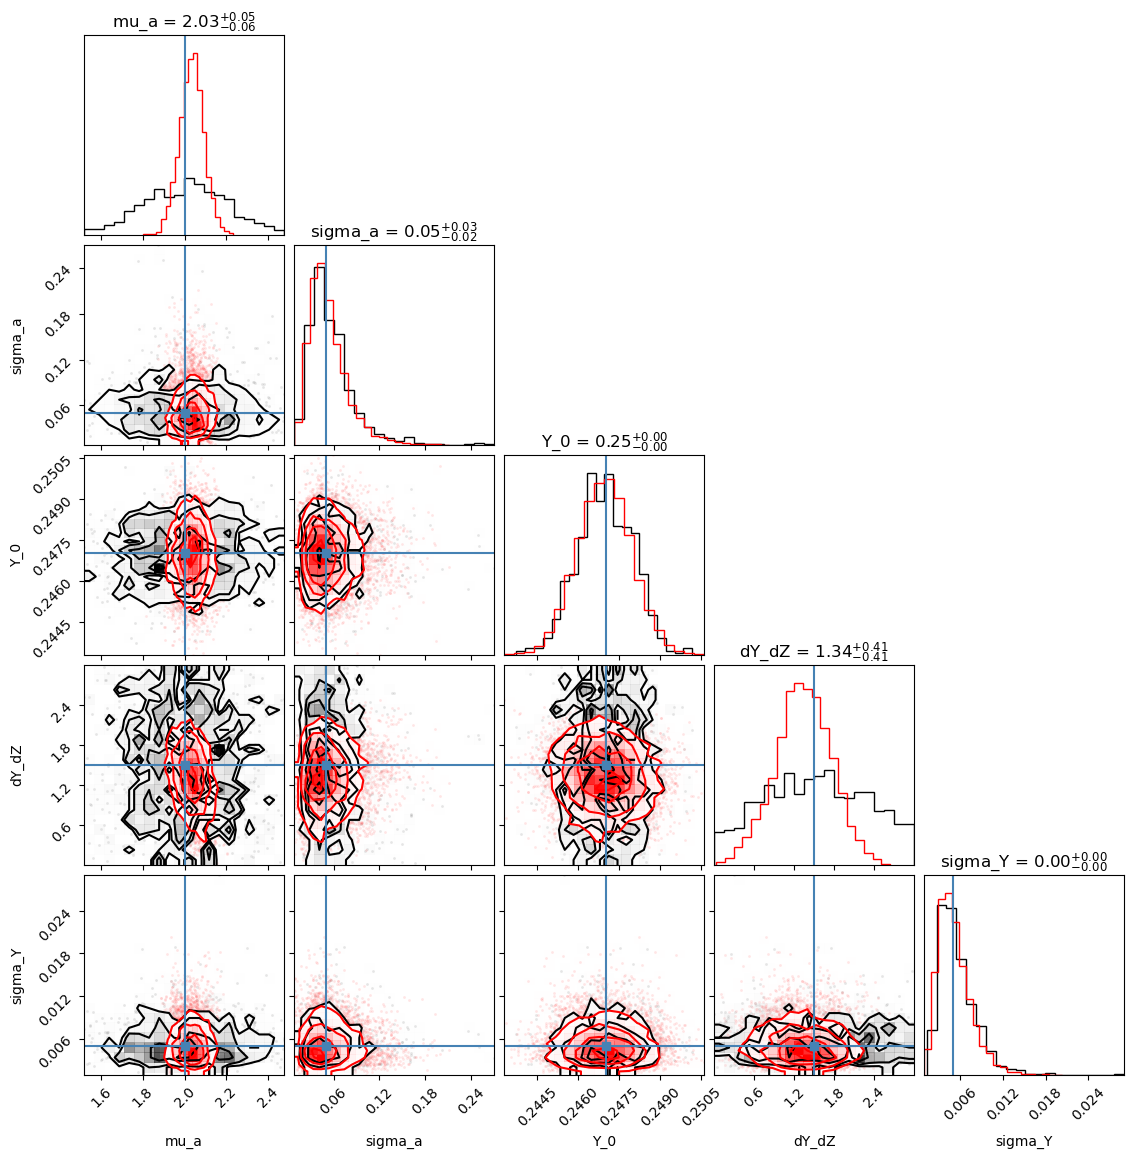

In [28]:
# limits = [(1.5, 2.5), (0.0, 0.4), (0.244, 0.250), (0.0, 3.0), (0.0, 0.04)]
limits = None
hist_kwargs = dict(density=True)
fig = corner(data, group="prior", var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs)

hist_kwargs["color"] = "r"
fig = corner(data, var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs,
             color="r", truths=truths, show_titles=True, fig=fig)


Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [29]:
error = truths - data.posterior
az.summary(error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]         0.081  0.091  -0.093    0.256      0.002    0.001    3485.0   
M_H[1]         0.026  0.093  -0.149    0.210      0.002    0.001    2639.0   
M_H[2]        -0.071  0.097  -0.252    0.107      0.001    0.001    4259.0   
M_H[3]        -0.057  0.090  -0.236    0.104      0.001    0.001    4606.0   
M_H[4]        -0.090  0.073  -0.195    0.044      0.001    0.001    2292.0   
...              ...    ...     ...      ...        ...      ...       ...   
log_numax[45]  0.010  0.010  -0.008    0.028      0.000    0.000    5295.0   
log_numax[46]  0.026  0.014   0.002    0.052      0.000    0.000    2206.0   
log_numax[47] -0.005  0.009  -0.022    0.012      0.000    0.000    1067.0   
log_numax[48] -0.013  0.009  -0.029    0.005      0.000    0.000    4807.0   
log_numax[49]  0.001  0.011  -0.020    0.020      0.000    0.000    3497.0   

               ess_tail  r_hat  
M_H[0]           3704.0    1.0  
M_H[1]           2954.0    1.0  
M_H[2]           4219.0    1.0  
M_H[3]           2837.0    1.0  
M_H[4]           2855.0    1.0  
...                 ...    ...  
log_numax[45]    5770.0    1.0  
log_numax[46]    5415.0    1.0  
log_numax[47]    3175.0    1.0  
log_numax[48]    6727.0    1.0  
log_numax[49]    5051.0    1.0  

[805 rows x 9 columns]

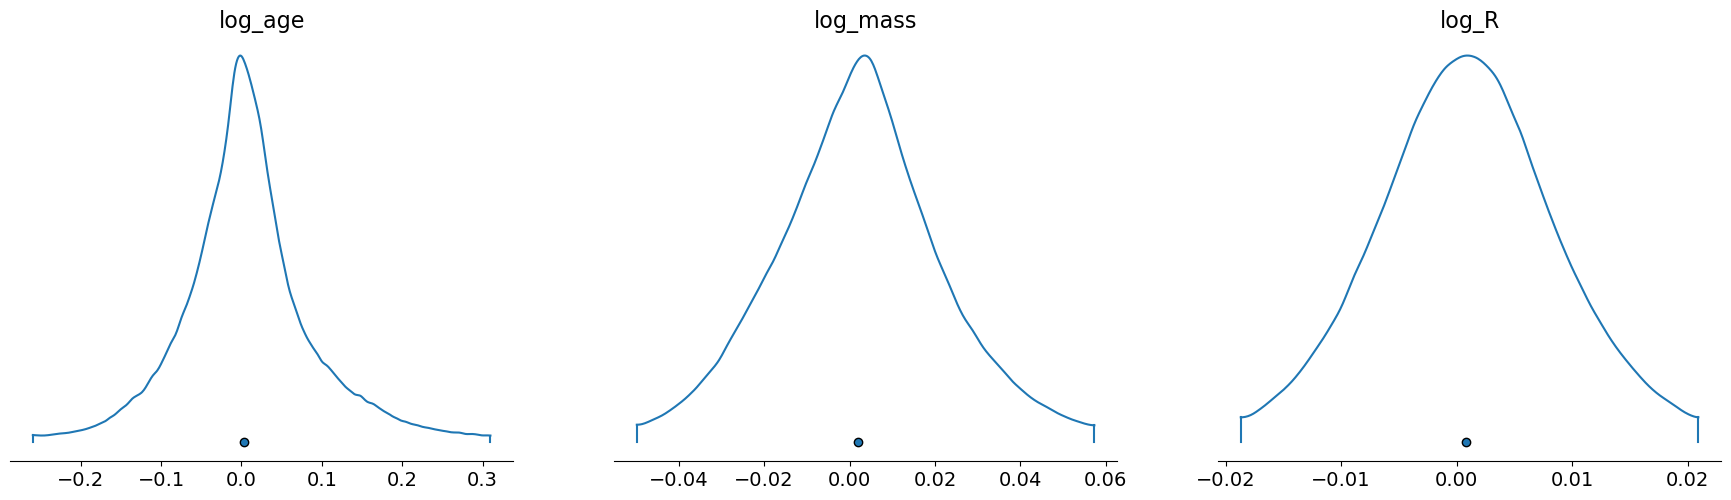

In [39]:
var_names = ["log_age", "log_mass", "log_R"]
az.plot_density(error, var_names=var_names, combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

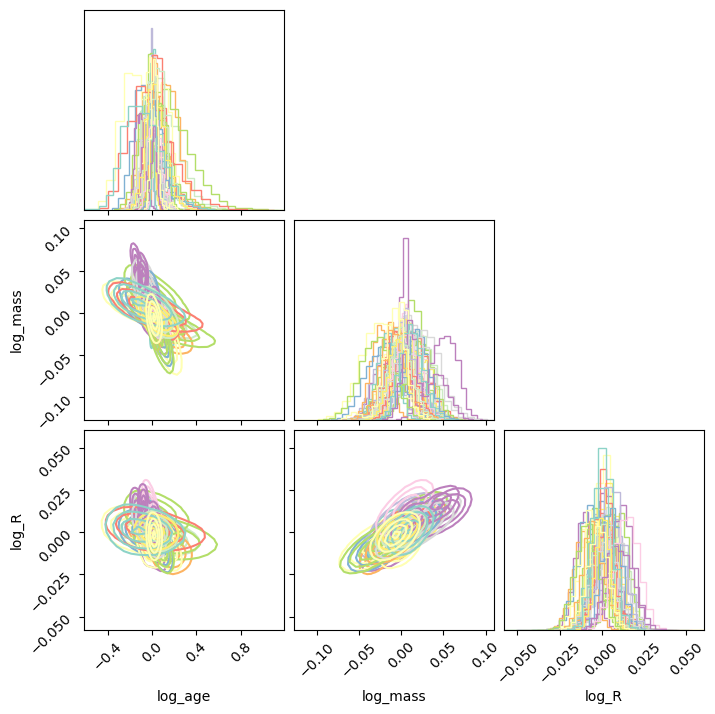

In [40]:
max_stars = num_stars
cmap = colormaps["Set3"]
fig = None
for star in range(max_stars):
    coords_ = {"star": star}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(error, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)